In [1]:
%matplotlib inline
from matplotlib import style, figure
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Display the row's columns and data in dictionary format
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11dae1b38>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [11]:
# Calculate the date 1 year ago from the last data point in the database
Last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
Year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
Year_ago

datetime.date(2016, 8, 23)

In [12]:
## Design a query to retrieve the last 12 months of precipitation data and plot the results
sel = [Measurement.date, 
       func.avg(Measurement.prcp)]
daily_averages = session.query(*sel).\
    filter(func.strftime('%Y-%m-%d', Measurement.date) >= '2016-08-24').\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

In [13]:
#Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(daily_averages, columns=['date', 'precip'])
df.set_index("date", inplace = True)

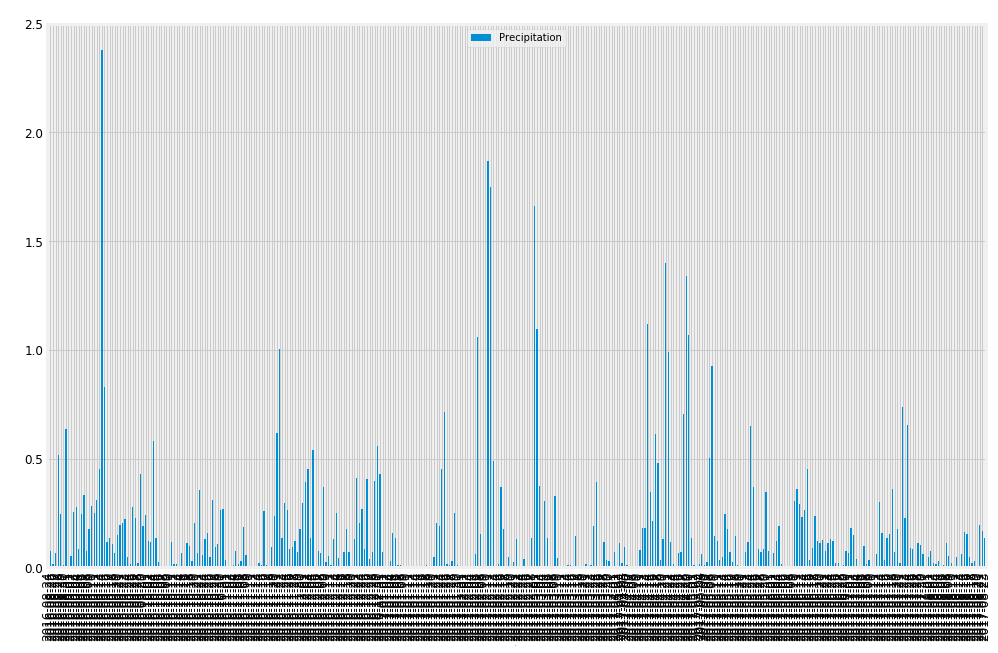

In [25]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = df[['precip']].plot(kind='bar', title =" ", figsize=(15, 10), fontsize=12)
ax.set_xlabel("date", fontsize=0)
ax.set_ylabel(" ", fontsize=12)
plt.legend(['Precipitation'], loc='upper center')
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precip
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [16]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
station_count

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.date)]
counts = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(Measurement.station.desc()).all()
counts

[('USC00519523', 2669),
 ('USC00519397', 2724),
 ('USC00519281', 2772),
 ('USC00518838', 511),
 ('USC00517948', 1372),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00513117', 2709),
 ('USC00511918', 1979)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
most_active = session.query(*sel).\
    filter(Measurement.station == "USC00519281").all()
most_active

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [19]:
descending = session.query(Measurement.date).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date.desc()).first()
descending
#last_date = descending.first()
#last_date

('2017-08-18')

Text(0.5, 0, 'Temperature (F)')

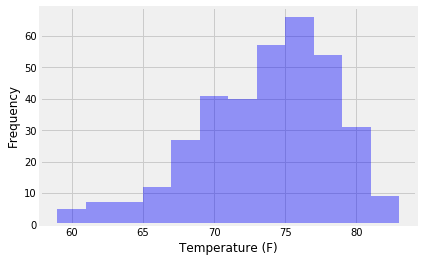

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
import seaborn as sns
most_temps = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(func.strftime('%Y-%m-%d', Measurement.date) >= '2016-08-19').all()

sns.distplot(most_temps, bins=12, kde=False, color='blue', rug=False);
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Temperature (F)', fontsize=12)


In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
lookup = calc_temps('2016-08-24', '2017-08-24')
lookup

[(58.0, 74.57894736842105, 87.0)]

In [27]:
df2 = pd.DataFrame(lookup, columns=['min', 'avg', 'max'])
#df.set_index("min", inplace = True)
df2

,min,avg,max
0,58.0,74.578947,87.0


In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
#fig, ax = plt.subplots()

yerr = df2('max')-df2('min')
x = range(len(lookup))
ax.boxplot(lookup), patch_artist=True)
ax.set_title('Trip Avg Temp')
fig.tight_layout()
plt.show()

yerr

TypeError: 'DataFrame' object is not callable

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
